**To-do:** Extract scripts from notebook and adapt to iterate over system size. Currently the notebook must be run for each system size individually and at the bottom of the notebook 'Q_vs_T' files for each system size are plotted together manually.


# Calculating order parameter Q as a function of temperature

This notebook allows you to calculate the order parameter Q based on the occupancy of Cu 2c sites and Zn 2d sites in kesterite-structured Cu2ZnSnS4 (CZTS). This order parameter has been used in a number of experimental studies investigating temperature-dependent Cu-Zn substitutional disorder in CZTS, such as [here](http://onlinelibrary.wiley.com/doi/10.1002/pssb.201600372/abstract).

The order parameter is given by:

Q = [ (Cu-on-2c + Zn-on-2d) - (Zn-on-2c + Cu-on-2d) ] / [ (Cu-on-2c + Zn-on-2d) + (Zn-on-2c + Cu-on-2d) ]

Where in a fully ordered system, all 2c sites should be occupied by Cu and all 2d sites by Zn. This situation corresponds to Q=1. For a fully disordered system, there is no preference for Cu or Zn to occupy the correct crystallographic site and Q=0.

## Eris simulation flags

The script takes input lattice configurations outputted from Eris in the format of input files for the gulp code. 

It is therefore necessary to set the **'SaveGULP'** flag in eris.cfs to true. 

Also, to get a gulp input file written after every MCMegaStep set the flag **'ExtraData'** also to true.

Ensure that MCMegaSteps is several multiples of MCEqmSteps to allow for lots of independent data to analyse.


## 1. Sort raw data from Eris and generate directory to store outputs from this analysis

In [1]:
%%bash

# Make directory to store outputs from Q calculation (if it doesn't already exist)
if [ ! -d "Q_data" ]; then
  mkdir Q_data
fi

# Moving data to a separate directory (if not done already)
if [ ! -d "GULP_inputs" ]; then
  mkdir GULP_inputs
  mv Gulp_* GULP_inputs
fi

## 2. User inputs

Firstly, the script must be run in the same directory as the gulp input files written by Eris.

The only inputs needed for the script to calculate Q versus simulation temperature are the lattice dimensions from the Eris simulation, the temperature range and increments used in the Eris simulation and to ensure that the correct name has been given for the gulp input files in the script below, where the simulation temperatures will be added into the filename later by the script.

In [2]:
############################## USER INPUTS #########################################

# Temperature range and step size from Eris simulation (as defined in cx1 submission script)
TMIN = 0
TMAX = 1000
TSTEP = 50

# Setting MCSteps (as defined in eris.cfg)
MCEqmSteps = 50
MCMegaSteps = 500

# Enter dimensions of lattice (as defined in eris-config.c)
X_dim = 12
Y_dim = 12
Z_dim = 12
#-------------------------------------------------------------------
# No edits below here needed

# Define step size so that we analyse outputs in increments of MCEqmSteps/10 
# We gather data 10x more regularly than the equilibriation time after our equilibration burn-in
# Define total number of outputs (portion of total MC steps) for each T to analyse
StepSize=MCEqmSteps/10
outputs_tot=(MCMegaSteps/StepSize)

## 3. Check that the list of gulp file names matches those output from Eris

Next, we generate the list of data files to calculate Q for, again, double check here that the script is using the same filenames for the gulp input files written by Eris. 


In [3]:
# Generating list containing input and output filenames for lattice configurations at each simulation T
input_files=[]
Q_param_files=[]
site_occ_files=[]
disorder_sites_files=[]
error_files=[]
order_files=[]
for T in range (TMIN, TMAX+TSTEP, TSTEP):
    T_formatted= str(T).zfill(4)
    for output in range (1, MCMegaSteps+1, int(StepSize)):
        output_formatted= str(output).zfill(5)
        site_occ_files.append("Q_data/site_occupancies_T_"+str(T_formatted)+"_MCS_"+str(output_formatted)+".txt")
        disorder_sites_files.append("Q_data/disordered_sites_T_"+str(T_formatted)+"_MCS_"+str(output_formatted)+".txt")
        error_files.append("Q_data/error_log_T_"+str(T_formatted)+"_MCS_"+str(output_formatted)+".txt")
        order_files.append("Q_data/order_log_T_"+str(T_formatted)+"_MCS_"+str(output_formatted)+".txt")
        input_files.append("GULP_inputs/Gulp_T_"+str(T_formatted)+"_MCS_"+str(output_formatted)+".in")
        Q_param_files.append("Q_data/Q_parameter_T_"+str(T_formatted)+"_MCS_"+str(output_formatted)+".txt")
        
print(input_files)

['GULP_inputs/Gulp_T_0000_MCS_00001.in', 'GULP_inputs/Gulp_T_0000_MCS_00006.in', 'GULP_inputs/Gulp_T_0000_MCS_00011.in', 'GULP_inputs/Gulp_T_0000_MCS_00016.in', 'GULP_inputs/Gulp_T_0000_MCS_00021.in', 'GULP_inputs/Gulp_T_0000_MCS_00026.in', 'GULP_inputs/Gulp_T_0000_MCS_00031.in', 'GULP_inputs/Gulp_T_0000_MCS_00036.in', 'GULP_inputs/Gulp_T_0000_MCS_00041.in', 'GULP_inputs/Gulp_T_0000_MCS_00046.in', 'GULP_inputs/Gulp_T_0000_MCS_00051.in', 'GULP_inputs/Gulp_T_0000_MCS_00056.in', 'GULP_inputs/Gulp_T_0000_MCS_00061.in', 'GULP_inputs/Gulp_T_0000_MCS_00066.in', 'GULP_inputs/Gulp_T_0000_MCS_00071.in', 'GULP_inputs/Gulp_T_0000_MCS_00076.in', 'GULP_inputs/Gulp_T_0000_MCS_00081.in', 'GULP_inputs/Gulp_T_0000_MCS_00086.in', 'GULP_inputs/Gulp_T_0000_MCS_00091.in', 'GULP_inputs/Gulp_T_0000_MCS_00096.in', 'GULP_inputs/Gulp_T_0000_MCS_00101.in', 'GULP_inputs/Gulp_T_0000_MCS_00106.in', 'GULP_inputs/Gulp_T_0000_MCS_00111.in', 'GULP_inputs/Gulp_T_0000_MCS_00116.in', 'GULP_inputs/Gulp_T_0000_MCS_00121.in',

## 4. Calculate that Q parameter!
Now we will calculate Q for each input file contained in the list above and average over several outputs for each T, in multiples of MCEqmSteps for de-coupled data.

In [4]:
%matplotlib inline
import sys
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd

# Defining temperature list from user input and initialising empty list to write Q as a function of T to
T = np.arange(TMIN, TMAX+TSTEP, TSTEP)
Q_vs_T =[]

# Defining row number where cation coords start and end based on supercell dimensions
cation_coord_start = 9+8*(X_dim//2)*(Y_dim//2)*(Z_dim//4)  # Skipping over S ions (9 lines of text, 8 S ions per 2x2x4 unit)
cation_coord_end = cation_coord_start+(X_dim*Y_dim*Z_dim)//2    # half of initial lattice contained gap sites which are not written to gulp input file

# Halving Z lattice dimension because half of initial lattice sites are empty, which are not written to the gulp input (see lattice initialisation method2 in eris-lattice.c)
Z=Z_dim//2  # /2 because gap sites from lattice[x][y][z] not written to gulp input
X=X_dim
Y=Y_dim

# Reading in data files and calculating Q for each T

# Loop to step over data files at each T
count = 0
for i in range (0, len(input_files), int(outputs_tot)):
    
    Q = []
    
    print("Calculating averaged Q for T = "+str(T[count])+" K lattice configuration")
    
    # Loop over input files for each T
    for j in range (i, i+int(outputs_tot-1), 1):
        # Reading in gulp input file and storing as a matrix where data[row from zero][col from zero]
        data = pd.read_csv(input_files[j], names =["species", "core", "x", "y", "z", "charge"], delimiter=" ").as_matrix()
        # Initialising empty lists for occupancy of 2a, 2b, 2c and 2d sites + a list containing coordinates (full gulp input row) for disordered sites
        a=[]
        b=[]
        c=[]
        d=[]
        disordered=[]
        order_log=[]
        error_log=[]
        Cu_2c=0
        Zn_2d=0
        Cu_2d=0
        Zn_2c=0
        # Opening files to write to
        Q_param_file=open(Q_param_files[j],'w')
        occupancies_file=open(site_occ_files[j],'w')
        disorder_file=open(disorder_sites_files[j], 'w')
        error_log_file=open(error_files[j], 'w')
        order_log_file=open(order_files[j], 'w')
    
        # ----- Begin calculation of Q parameter -------------------------------------
        # Initialising number of rows contained within each x-loop iteration
        x_block=0

        for x in range(0, X):
            for y in range(0, Y):
                # --------------------- even x,y -----------------------------------------------
                if ( math.fmod(x, 2) == 0 and math.fmod(y, 2) == 0 ):
                    # Looping over list of z (repeats every 2 species)
                    for z in range(cation_coord_start, Z+cation_coord_start, 2):
                    
                        # Writing species to 2b site file
                        b.append(data[z + (y*Z) + x_block][0])
                        # Checking if first of two repeating species for even x, even y list is correct
                        if data[z + (y*Z) + x_block][0] == "Sn":    ### 2b site
                            order_log.append("yes! - Sn is Sn")
                        else: 
                            error_log.append("uh oh! Sn error! -- "+str(data[z + (y*Z) + x_block][0]))
                            print("Looks like there's some Sn disorder! Has Sn been unfrozen?")
                            disordered.append(str(data[z + (y*Z) + x_block][:]))
   
                        # Writing species to 2a site file
                        a.append(data[z+1 + (y*Z) + x_block][0])
                        # Checking if second of two repeating species for even x, even y list is correct
                        if data[z+1 + (y*Z) + x_block][0] == "Cu":    ### 2a site
                            order_log.append("yes! - Cu is Cu")
                        else:
                            error_log.append("uh oh! Cu error! -- "+str(data[z+1 + (y*Z) + x_block][0]))
                            print("Cu is not on the 2a site - are you simulating 3D Cu-Zn disorder?")
                            disordered.append(str(data[z+1 + (y*Z) + x_block][:]))  
 
                # ------------------ even x, odd y --------------------------------------------
                elif ( math.fmod(x, 2) == 0 and math.fmod(y, 2) != 0 ):
                    # Loop over list of length Z
                    for z in range(cation_coord_start, Z+cation_coord_start, 2):
                    
                        # Writing species to 2d site file
                        d.append(data[z + (y*Z) + x_block][0])
                        if data[z + (y*Z) + x_block][0] == "Zn":   ### 2d site
                            order_log.append("yes! - Zn is Zn!")
                            Zn_2d += 1
                        else:
                            error_log.append("uh oh! Zn error! -- "+str(data[z + (y*Z) + x_block][0]))
                            disordered.append(str(data[z + (y*Z) + x_block][:]))
                            if data[z + (y*Z) + x_block][0] == "Cu":
                                Cu_2d += 1

                        # Writing species to 2c site file
                        c.append(data[z+1 + (y*Z) + x_block][0])
                        if data[z+1 + (y*Z) + x_block][0] == "Cu":   ### 2c site
                            order_log.append("yes! - Cu is Cu again")
                            Cu_2c += 1
                        else:
                            error_log.append("uh oh! error for 2c Cu -- "+str(data[z+1 + (y*Z) + x_block][0]))
                            disordered.append(str(data[z+1 + (y*Z) + x_block][:]))
                            if data[z+1 + (y*Z) + x_block][0] == "Zn":
                                Zn_2c += 1

                # --------------------- odd x,even y -----------------------------------------------
                if ( math.fmod(x, 2) != 0 and math.fmod(y, 2) == 0 ):
  
                    # Looping over list of z (repeats every 2 species)
                    for z in range(cation_coord_start, Z+cation_coord_start, 2):
  
                        # Writing species to 2c site file
                        c.append(data[z + (y*Z) + x_block][0])
                        # Checking if first of two repeating species for even x, even y list is correct
                        if data[z + (y*Z) + x_block][0] == "Cu":    ### 2c site
                            order_log.append("yes! - Cu is Cu again")
                            Cu_2c += 1
                        else:
                            error_log.append("uh oh! Cu 2c error! -- "+str(data[z + (y*Z) + x_block][0]))
                            disordered.append(str(data[z + (y*Z) + x_block][:]))
                        if data[z + (y*Z) + x_block][0] == "Zn":
                            Zn_2c += 1
         
                        # Writing species to 2d site file
                        d.append(data[z+1 + (y*Z) + x_block][0]) 
                        # Checking if second of two repeating species for even x, even y list is correct
                        if data[z+1 + (y*Z) + x_block][0] == "Zn":    ### 2d site
                            order_log.append("yes! - Zn is Zn")
                            Zn_2d += 1
                        else:
                            error_log.append("uh oh! Zn error! -- "+str(data[z+1 + (y*Z) + x_block][0]))
                            disordered.append(str(data[z+1 + (y*Z) + x_block][:]))
                        if data[z+1 + (y*Z) + x_block][0] == "Cu":
                            Cu_2d += 1   

                # ------------------ odd x,y -----------------------------------------------------
                elif ( math.fmod(x, 2) != 0 and math.fmod(y, 2) != 0 ):

                    # Loop over list of length Z
                    for z in range(cation_coord_start, Z+cation_coord_start, 2):
    
                        # Writing species to 2a site file
                        a.append(data[z + (y*Z) + x_block][0])
                        if data[z + (y*Z) + x_block][0] == "Cu":     ### 2a site
                            order_log.append("yes! - Cu is Cu!")
                        else:
                            error_log.append("uh oh! Cu error! --  "+str(data[z + (y*Z) + x_block][0]))
                            print("Cu is not on the 2a site - are you simulating 3D Cu-Zn disorder?")
                            disordered.append(str(data[z + (y*Z) + x_block][:]))

                        # Writing species to 2b site file
                        b.append(data[z+1 + (y*Z) + x_block][0])
                        if data[z+1 + (y*Z) + x_block][0] == "Sn":    ### 2b site
                            order_log.append("yes! - Sn is Sn")
                        else:
                            error_log.append("uh oh! error for Sn --  "+str(data[z+1 + (y*Z) + x_block][0]))
                            print("Looks like there's some Sn disorder! Has Sn been unfrozen?")
                            disordered.append(str(data[z+1 + (y*Z) + x_block][:]))

                # --------------------------------------------------------------------------------

            # Updating number of rows already checked from previous x-loop iteration
            x_block += Y*Z


        # ------------------------------------------------------------------------------------
        # Writing lists to output files

        for i in order_log:
            order_log_file.write(i+'\n')
        for i in error_log:
            error_log_file.write(i+'\n') 

        df = pd.DataFrame({'# 2a' : a, '2b' : b, '2c' : c, '2d' : d})
        df.to_csv(occupancies_file, sep='\t')

        for i in disordered:
            disorder_file.write(i+'\n')

        # Calculating Q parameter
        Q.append(float( (Cu_2c + Zn_2d) - (Zn_2c + Cu_2d) ) / ( (Cu_2c + Zn_2d) + (Zn_2c + Cu_2d) ) )

        Q_param_file.write('# Q ='+str(Q)+'\n')
        Q_param_file.write('# Where Q = [ (Cu-on-2c + Zn-on-2d) - (Zn-on-2c + Cu-on-2d) ] / [ (Cu-on-2c + Zn-on-2d) + (Zn-on-2c + Cu-on-2d) ]'+'\n')
        Q_param_file.write('# Q=1 corresponds to perfect order, Q=0 is complete disorder where Cu and Zn (within the Cu-Zn plane only) show no preference for their correct crystallographic site'+'\n')
        Q_param_file.write('# Where Cu is on the 2c site and Zn on the 2d site in ordered CZTS'+'\n')
        Q_param_file.write('# Cu_2c Zn_2d Cu_2d Zn_2c'+'\n')  
        Q_param_file.write(str(Cu_2c)+'   '+str(Zn_2d)+'   '+str(Cu_2d)+'   '+str(Zn_2c))

        order_log_file.close()
        error_log_file.close()
        disorder_file.close()
        occupancies_file.close()
        Q_param_file.close()
    
    # Writing Q to file to plot in ipython notebook
    Q_av = sum(Q)/outputs_tot
    Q_vs_T.append(Q_av)
    
    count += 1

Calculating averaged Q for T = 0 K lattice configuration
Calculating averaged Q for T = 50 K lattice configuration
Calculating averaged Q for T = 100 K lattice configuration
Calculating averaged Q for T = 150 K lattice configuration
Calculating averaged Q for T = 200 K lattice configuration
Calculating averaged Q for T = 250 K lattice configuration
Calculating averaged Q for T = 300 K lattice configuration
Calculating averaged Q for T = 350 K lattice configuration
Calculating averaged Q for T = 400 K lattice configuration
Calculating averaged Q for T = 450 K lattice configuration
Calculating averaged Q for T = 500 K lattice configuration
Calculating averaged Q for T = 550 K lattice configuration
Calculating averaged Q for T = 600 K lattice configuration
Calculating averaged Q for T = 650 K lattice configuration
Calculating averaged Q for T = 700 K lattice configuration
Calculating averaged Q for T = 750 K lattice configuration
Calculating averaged Q for T = 800 K lattice configuration


## 5. Plot Q vs. T for given system size

Now, we will plot Q against simulation temperature for this system.

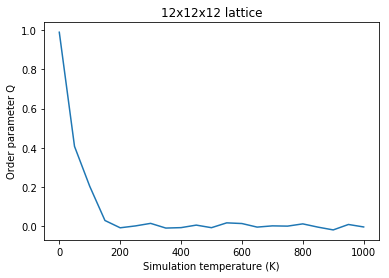

In [5]:
plt.title(str(X_dim)+'x'+str(Y_dim)+'x'+str(Z_dim)+' lattice')
plt.xlabel('Simulation temperature (K)')
plt.ylabel('Order parameter Q')
plt.plot(T, Q_vs_T)
plt.show()

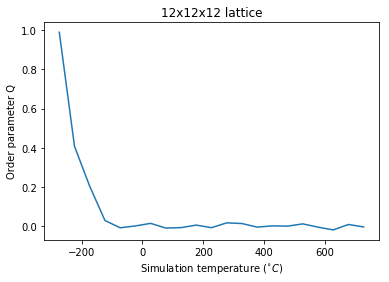

In [6]:
# Convert above plot to be in deg C for easier comparison to experiment
plt.title(str(X_dim)+'x'+str(Y_dim)+'x'+str(Z_dim)+' lattice')
plt.xlabel('Simulation temperature ($^{\circ}C$)')
plt.ylabel('Order parameter Q')
#plt.xlim(50,250)
plt.plot(T-273.15, Q_vs_T)
plt.show()

Finally, we will output this data so that we can plot the order parameter for several different systems together later if we wish to.

In [7]:
# Writing T's and Q's to a file to plot multiple systems together later
df2 = pd.DataFrame({'# T' : T, 'Q' : Q_vs_T})
QvsT_file='Q_vs_T_'+str(X_dim)+'x'+str(Y_dim)+'x'+str(Z_dim)+'.dat'
df2.to_csv(QvsT_file, sep=' ', index=False, header=False)
#df2.to_csv(QvsT_file, sep='\t')

## 6. Investigating finite size effects

To plot multiple different sized systems together, repeat the above analysis for different sized systems and then make sure to have the Q_vs_T_XxYxZ.dat file for each system in the same directory before running the script below.

This is a bit repetitive, may want to adapt this notebook as a full script that loops over system size to generate the plot below.

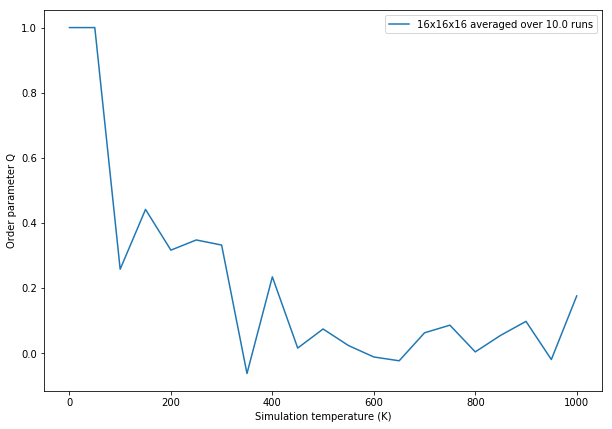

In [8]:
# Enter dimensions of the systems
# System 1
X2 = 12
Y2 = 12
Z2 = 12
# System 2
X1 = 16
Y1 = 16
Z1 = 16

import numpy as np
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
figsize(10, 7)

# Plot multiple systems together
file1= np.genfromtxt('Q_vs_T_'+str(X1)+'x'+str(Y1)+'x'+str(Z1)+'.dat', delimiter = ' ')
file2= np.genfromtxt('Q_vs_T_'+str(X1)+'x'+str(Y1)+'x'+str(Z1)+'.dat', delimiter = ' ')

plt.xlabel('Simulation temperature (K)')
plt.ylabel('Order parameter Q')
plt.plot(file1[:,0], file1[:,1], label=str(X1)+'x'+str(Y1)+'x'+str(Z1)' averaged over '+str(outputs_tot)+' runs')
plt.plot(file1[:,0], file1[:,1], label=str(X2)+'x'+str(Y2)+'x'+str(Z2)' averaged over '+str(outputs_tot)+' runs')

plt.legend()
plt.show()